In [9]:
# Phase 0: Notebook全体で使う共通ライブラリをインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from janome.tokenizer import Tokenizer
import cv2
import requests
from io import BytesIO
from PIL import Image
import mediapipe as mp

print("✅ ライブラリ読み込み完了")


✅ ライブラリ読み込み完了


In [10]:
# 📥 データ読み込み（ファイル名は適宜変更）
df = pd.read_excel("youtube_dataset_20250605.xlsx")

# 欠損処理
df["title"] = df["title"].fillna("")
df["categoryId"] = pd.to_numeric(df["categoryId"], errors="coerce").fillna(-1).astype(int)
df["viewCount"] = pd.to_numeric(df["viewCount"], errors="coerce").fillna(0)
df["publishedAt"] = pd.to_datetime(df["publishedAt"])

# 投稿日時特徴量
df["weekday"] = df["publishedAt"].dt.weekday
df["hour"] = df["publishedAt"].dt.hour
df["is_weekend"] = df["weekday"].isin([5, 6]).astype(int)
df["is_month_start"] = df["publishedAt"].dt.is_month_start.astype(int)
df["is_month_end"] = df["publishedAt"].dt.is_month_end.astype(int)


In [11]:
from janome.tokenizer import Tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer

# 日本語トークナイズ
tokenizer = Tokenizer()
def tokenize_japanese(text):
    return [token.base_form for token in tokenizer.tokenize(text)
            if token.part_of_speech.split(',')[0] in ['名詞', '動詞', '形容詞']]

# TF-IDFベクトル化（100次元）
vectorizer = TfidfVectorizer(tokenizer=tokenize_japanese, token_pattern=None, max_features=100)
tfidf_matrix = vectorizer.fit_transform(df["title"])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=[f"tfidf_{w}" for w in vectorizer.get_feature_names_out()])
tfidf_df.index = df.index


In [12]:
import cv2
import requests
from io import BytesIO
from PIL import Image
from sklearn.cluster import KMeans
import mediapipe as mp

mp_face = mp.solutions.face_detection
face_detector = mp_face.FaceDetection(model_selection=1, min_detection_confidence=0.5)

thumbnail_cols = [
    "brightness", "face_count", "telop_ratio",
    "r_mean", "g_mean", "b_mean",
    "h_mean", "s_mean", "v_mean"
] + [f"color_ratio_{i}" for i in range(5)]

def extract_thumbnail_features_mediapipe(url):
    try:
        response = requests.get(url, timeout=5)
        img = Image.open(BytesIO(response.content)).convert("RGB").resize((128, 128))
        img_np = np.array(img)

        # 明度
        brightness = np.mean(np.array(img.convert("L")))

        # 顔検出
        results = face_detector.process(cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR))
        face_count = len(results.detections) if results.detections else 0

        # テロップ（白 or 黄）
        white = (img_np[:, :, 0] > 200) & (img_np[:, :, 1] > 200) & (img_np[:, :, 2] > 200)
        yellow = (img_np[:, :, 0] > 200) & (img_np[:, :, 1] > 200) & (img_np[:, :, 2] < 100)
        telop_ratio = (white | yellow).sum() / (img_np.shape[0] * img_np.shape[1])

        # RGB平均
        r_mean = img_np[:, :, 0].mean()
        g_mean = img_np[:, :, 1].mean()
        b_mean = img_np[:, :, 2].mean()

        # HSV平均
        hsv = cv2.cvtColor(img_np, cv2.COLOR_RGB2HSV).astype("float32") / 255.0
        h_mean = hsv[:, :, 0].mean()
        s_mean = hsv[:, :, 1].mean()
        v_mean = hsv[:, :, 2].mean()

        # 主要色割合
        flat = img_np.reshape(-1, 3)
        kmeans = KMeans(n_clusters=5, n_init="auto", random_state=42)
        labels = kmeans.fit_predict(flat)
        color_ratio = np.bincount(labels, minlength=5) / len(labels)

        return pd.Series([
            brightness, face_count, telop_ratio,
            r_mean, g_mean, b_mean,
            h_mean, s_mean, v_mean,
            *color_ratio
        ])
    except:
        return pd.Series([np.nan] * 14)

# 適用 & 欠損補完
thumbnail_df = df["thumbnail"].fillna("").apply(extract_thumbnail_features_mediapipe)
thumbnail_df.columns = thumbnail_cols
thumbnail_df = thumbnail_df.fillna(thumbnail_df.mean())

# 結合
df = pd.concat([df, thumbnail_df], axis=1)


In [13]:
# 特徴量の組み合わせ
feature_cols = ["categoryId", "weekday", "hour", "is_weekend", "is_month_start", "is_month_end"] + thumbnail_cols
X = pd.concat([df[feature_cols].reset_index(drop=True), tfidf_df.reset_index(drop=True)], axis=1)

# 目的変数（log変換）
y = np.log1p(df["viewCount"])


In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"✅ 学習完了！RMSE（logスケール）: {rmse:.4f}")


✅ 学習完了！RMSE（logスケール）: 1.1023


C:\Users\Owner\anaconda3\envs\faceenv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12377 (\N{HIRAGANA LETTER SU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Owner\anaconda3\envs\faceenv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12366 (\N{HIRAGANA LETTER GI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Owner\anaconda3\envs\faceenv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12427 (\N{HIRAGANA LETTER RU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Owner\anaconda3\envs\faceenv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 32670 (\N{CJK UNIFIED IDEOGRAPH-7F9E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Owner\anaconda3\envs\faceenv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 24677 (\N{CJK UNIFIED IDEOGRA

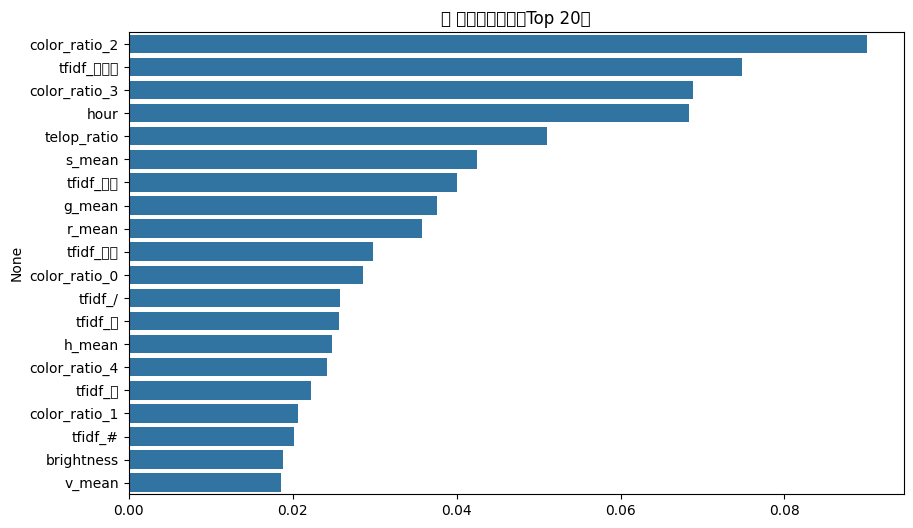

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

feat_imp = pd.Series(model.feature_importances_, index=X.columns)
top_imp = feat_imp.sort_values(ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_imp.values, y=top_imp.index)
plt.title("🎯 重要な特徴量（Top 20）")
plt.show()


In [16]:
def evaluate_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return np.sqrt(mean_squared_error(y_test, y_pred))

X_base = pd.concat([df[["categoryId"]].reset_index(drop=True), tfidf_df.reset_index(drop=True)], axis=1)
X_full = pd.concat([df[feature_cols].reset_index(drop=True), tfidf_df.reset_index(drop=True)], axis=1)

print("▶️ RMSE（TF-IDF + categoryId）:", evaluate_model(X_base, y))
print("▶️ RMSE（Full features）:", evaluate_model(X_full, y))


▶️ RMSE（TF-IDF + categoryId）: 1.0490233933345334
▶️ RMSE（Full features）: 1.102326085357406


In [17]:
thumbnail_cols = [
    "brightness", "face_count", "telop_ratio",
    "r_mean", "g_mean", "b_mean",
    "h_mean", "s_mean", "v_mean"
] + [f"color_ratio_{i}" for i in range(5)]


In [18]:
import pandas as pd
import numpy as np

# データ読み込み
df = pd.read_excel("youtube_dataset.xlsx")

# 必要な型変換・欠損補完
df["title"] = df["title"].fillna("")
df["categoryId"] = pd.to_numeric(df["categoryId"], errors="coerce").fillna(-1).astype(int)
df["viewCount"] = pd.to_numeric(df["viewCount"], errors="coerce").fillna(0)
df["publishedAt"] = pd.to_datetime(df["publishedAt"])

# 投稿時特徴量
df["weekday"] = df["publishedAt"].dt.weekday
df["hour"] = df["publishedAt"].dt.hour
df["is_weekend"] = df["weekday"].isin([5,6]).astype(int)
df["is_month_start"] = df["publishedAt"].dt.is_month_start.astype(int)
df["is_month_end"] = df["publishedAt"].dt.is_month_end.astype(int)


In [19]:
from janome.tokenizer import Tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer

tokenizer = Tokenizer()
def tokenize_japanese(text):
    return [token.base_form for token in tokenizer.tokenize(text)
            if token.part_of_speech.split(',')[0] in ['名詞', '動詞', '形容詞']]

vectorizer = TfidfVectorizer(tokenizer=tokenize_japanese, token_pattern=None, max_features=100)
tfidf_matrix = vectorizer.fit_transform(df["title"])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=[f"tfidf_{w}" for w in vectorizer.get_feature_names_out()])
tfidf_df.index = df.index


In [20]:
import mediapipe as mp
import cv2
import numpy as np
from PIL import Image
import requests
from io import BytesIO
from sklearn.cluster import KMeans

# Mediapipe 初期化
mp_face_detection = mp.solutions.face_detection
face_detector = mp_face_detection.FaceDetection(model_selection=0, min_detection_confidence=0.5)

def extract_all_thumbnail_features_mediapipe(url):
    try:
        response = requests.get(url, timeout=5)
        img = Image.open(BytesIO(response.content)).convert("RGB").resize((128, 128))
        img_np = np.array(img)

        results = face_detector.process(img_np)
        face_count = len(results.detections) if results.detections else 0

        gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
        brightness = gray.mean()

        edges = cv2.Canny(gray, 100, 200)
        contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        telop_area = sum(cv2.contourArea(c) for c in contours)
        telop_ratio = telop_area / (128 * 128)

        r_mean = img_np[:, :, 0].mean()
        g_mean = img_np[:, :, 1].mean()
        b_mean = img_np[:, :, 2].mean()

        hsv = cv2.cvtColor(img_np, cv2.COLOR_RGB2HSV)
        h_mean = hsv[:, :, 0].mean()
        s_mean = hsv[:, :, 1].mean()
        v_mean = hsv[:, :, 2].mean()

        pixels = img_np.reshape(-1, 3)
        kmeans = KMeans(n_clusters=5, n_init=5).fit(pixels)
        hist, _ = np.histogram(kmeans.labels_, bins=np.arange(6))
        color_ratio = hist / hist.sum()

        return pd.Series(np.concatenate([
            [brightness, face_count, telop_ratio],
            [r_mean, g_mean, b_mean],
            [h_mean, s_mean, v_mean],
            color_ratio
        ]))
    except:
        return pd.Series([np.nan] * 14)

# 適用
thumbnail_df = df["thumbnail"].fillna("").apply(extract_all_thumbnail_features_mediapipe)
thumbnail_df.columns = thumbnail_cols
thumbnail_df = thumbnail_df.fillna(thumbnail_df.mean())  # 欠損補完

# 結合
df = pd.concat([df, thumbnail_df], axis=1)


In [21]:
feature_cols = [
    "categoryId", "weekday", "hour", "is_weekend", "is_month_start", "is_month_end"
] + thumbnail_cols

X = pd.concat([df[feature_cols].reset_index(drop=True), tfidf_df.reset_index(drop=True)], axis=1)
y = np.log1p(df["viewCount"])


In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"✅ モデル学習完了！RMSE（logスケール）: {rmse:.4f}")


✅ モデル学習完了！RMSE（logスケール）: 1.0594


In [23]:
# 🔁 再生時間の秒数化 → Shorts判定 → 除外
from isodate import parse_duration

df["duration_seconds"] = df["duration"].apply(lambda x: parse_duration(x).total_seconds())
df = df[df["duration_seconds"] > 60].copy()


ModuleNotFoundError: No module named 'isodate'

In [24]:
!pip install isodate

  Using cached isodate-0.7.2-py3-none-any.whl.metadata (11 kB)
Using cached isodate-0.7.2-py3-none-any.whl (22 kB)
